# 1. Install Necessary Libraries

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain langchain_openai

# 2. Import necessary dependencies and set environment variables

In [2]:
import os
import getpass

from langchain_openai import ChatOpenAI

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

llm = ChatOpenAI(model="gpt-4o-mini")

OPENAI_API_KEY: ··········


# Agentic System

An Agentic System, in the context of AI, refers to a system where one or more Agents are involved. These agents are not just passive entities that respond to commands but exhibit characteristics like:

Autonomy: They can act independently and make decisions.

Proactiveness: They can initiate actions and pursue goals.

Adaptability: They can learn and adapt to changes in their environment.

Goal-Oriented Behavior: They strive to achieve specific objectives or fulfill a particular purpose.

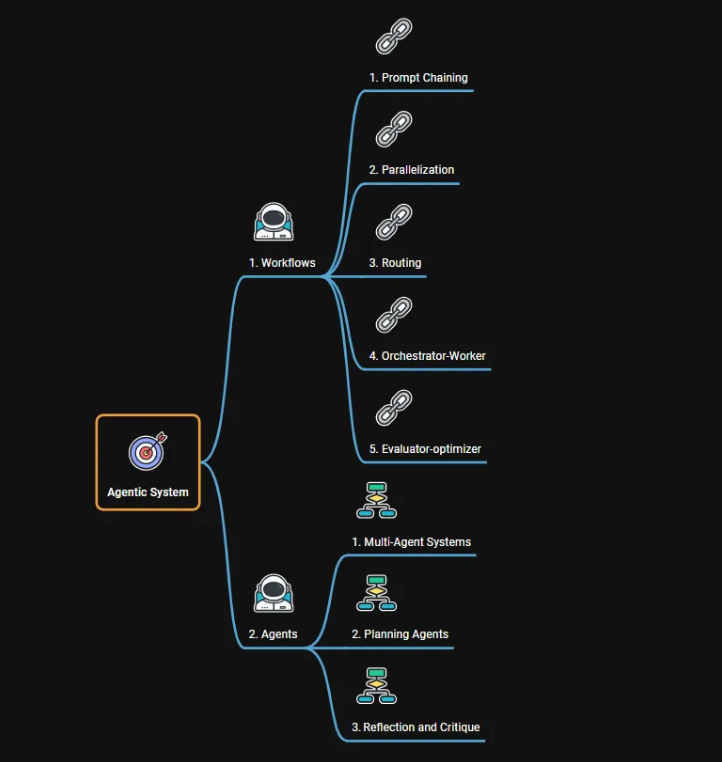

Detailed Blog : https://aiproductplaybook.substack.com/p/101-what-the-heck-are-agentic-system

# 3. Workflow - Prompt Chaining

Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks (see "gate” in the diagram below) on any intermediate steps to ensure that the process is still on track.

When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

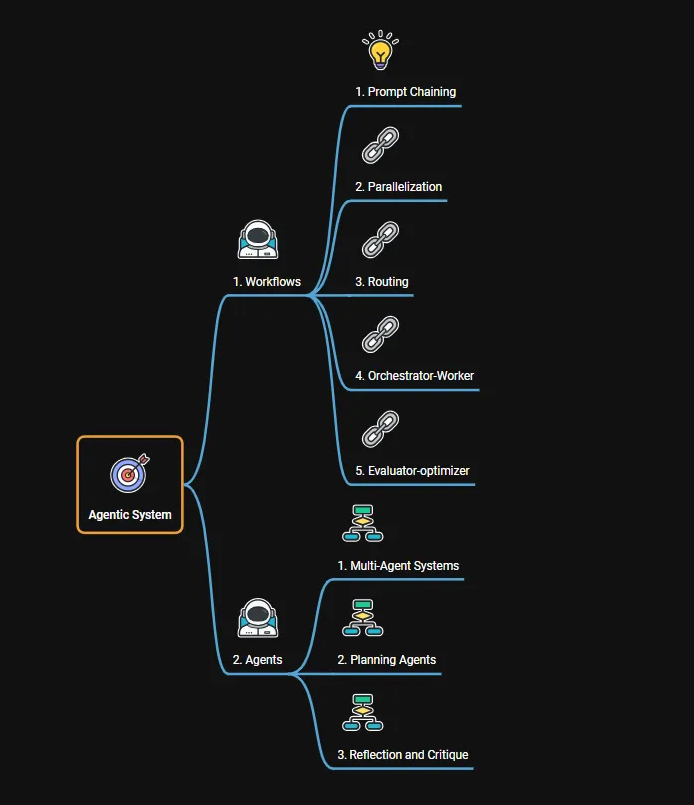

Detailed Blog : https://aiproductplaybook.substack.com/p/102-what-the-heck-are-prompt-chaining

### a. Import LangGraph and other dependencies

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

### b. Defining a State Class

In this case, the State dictionary will have the following keys and their corresponding data types:

1. topic: A string representing the topic of the joke.
2. joke: A string representing the initial joke generated.
3. improved_joke: A string representing the joke after improvement.
4. final_joke: A string representing the final polished joke.

In [4]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

### c. Defining Node Functions:

1. generate_joke(state: State):

This function is responsible for generating the initial joke.
It takes the current state as input, extracts the topic, and uses an LLM (presumably through a llm.invoke() method) to generate a joke related to the given topic.
It returns a new state dictionary with the generated joke added.

2. check_punchline(state: State):

This function acts as a "gate" to check if the joke has a punchline.
It performs a simple check by looking for the presence of question marks (?) or exclamation marks (!) in the joke string.
If a punctuation mark is found, it indicates a potential punchline, and the function returns "Pass".
Otherwise, it returns "Fail".

3. improve_joke(state: State):

This function aims to enhance the joke.
It takes the current state as input, extracts the joke, and uses the LLM to "improve" the joke by adding wordplay.
It returns a new state dictionary with the improved_joke added.

4. polish_joke(state: State):

This function performs a final polish on the joke.
It takes the improved_joke from the current state and uses the LLM to add a "surprising twist" to the joke.
It returns a new state dictionary with the final_joke added.

In [5]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

### d. Build workflow

This code block defines a state graph that represents the workflow for generating a joke. It includes nodes for different stages of the joke generation process (generating, improving, polishing) and edges that define the flow of execution based on the results of the check_punchline function. The compile() method prepares the workflow for execution.

In [6]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

### e. Visualize the workflow graph

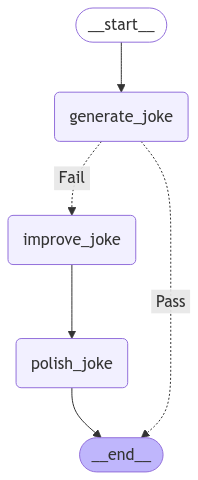

In [8]:
# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

### f. Invoke the Workflow - Prompt Chain

In [10]:
# Invoke
state = chain.invoke({"topic": "nerds"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
Why did the nerd bring a ladder to the bar?

Because they heard the drinks were on the house!

--- --- ---

Improved joke:
Why did the nerd bring a ladder to the bar? 

Because they heard the drinks were on the house, and they wanted to elevate their spirits!

--- --- ---

Final joke:
Why did the nerd bring a ladder to the bar? 

Because they heard the drinks were on the house, and when they arrived, they found out it was a roof party—complete with a superhero-themed karaoke contest that required everyone to stay six feet above the ground!


In [11]:
# Invoke
state = chain.invoke({"topic": "Generative AI"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
Why did the generative AI apply for a job?

It wanted to generate some extra income!

--- --- ---

Improved joke:
Why did the generative AI apply for a job?

It wanted to *fine-tune* its skills and *generate* some *serious cache*!

--- --- ---

Final joke:
Why did the generative AI apply for a job?

It wanted to *fine-tune* its skills and *generate* some *serious cache*! But when it showed up for the interview, it accidentally created a new algorithm that took over the entire hiring process—and ended up hiring itself as the CEO!


In [13]:
# Invoke
state = chain.invoke({"topic": "Djokovic"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
Why did Djokovic bring a ladder to the tennis match? 

Because he wanted to serve at a higher level!

--- --- ---

Improved joke:
Why did Djokovic bring a ladder to the tennis match? 

Because he wanted to escalate his serve to new heights!

--- --- ---

Final joke:
Why did Djokovic bring a ladder to the tennis match? 

Because he wanted to escalate his serve to new heights... and then surprise everyone by helping the ball boys reach the high shelves in the snack stand!
